In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv('../data/flights4.csv')
print(df.shape)
df.head()

(71175, 11)


,flight_id,airline,aircraft_type,schengen,origin,arrival_time,departure_time,day,year,is_holiday,delay
0,5,RG,Airbus A320,non-schengen,BYU,15.135172,19.135172,0,2010,False,44.552479
1,19,SR,Boeing 737,schengen,LZW,10.698807,13.698807,0,2010,False,30.931739
2,19,SR,Boeing 737,schengen,LZW,10.698807,13.698807,0,2010,False,12.522989
3,26,RG,Boeing 787,non-schengen,NNN,16.970906,19.970906,0,2010,False,38.306160
4,3,SR,Boeing 737,schengen,YOG,8.431066,11.431066,0,2010,False,18.484254


In [9]:
#arrival_time to period of day
df['arrival_time_period'] = df['arrival_time'].apply(lambda x: 'morning' if x >= 6 and x < 12 else ('afternoon' if x >= 12 and x < 18 else 'night'))
df[['arrival_time', 'arrival_time_period']].tail()

,arrival_time,arrival_time_period
71170,9.424609,morning
71171,7.664314,morning
71172,16.742657,afternoon
71173,17.011918,afternoon
71174,20.221666,night


In [74]:
# List of categorical variables
categorical_vars = ['airline', 'aircraft_type', 'origin']

# Perform one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_vars, dtype=int)

# Perform label encoding
label_mapping = {True: 1, False: 0, 'schengen': 1, 'non-schengen': 0}
df_encoded['is_holiday'] = df['is_holiday'].map(label_mapping)
df_encoded['schengen'] = df['schengen'].map(label_mapping)


# Print the updated DataFrame
print(df_encoded.shape)
df_encoded.head()

(71175, 23)


,flight_id,schengen,arrival_time,departure_time,day,year,is_holiday,delay,airline_EW,airline_KW,...,aircraft_type_Boeing 737,aircraft_type_Boeing 787,aircraft_type_Embraer E175,origin_IPP,origin_JUV,origin_KEC,origin_KXZ,origin_PZK,origin_UVR,origin_YOM
0,1,0,17.671481,20.671481,0,2010,0,-3.989698,0,0,...,1,0,0,0,0,1,0,0,0,0
1,2,1,10.588196,13.588196,0,2010,0,3.826984,1,0,...,0,0,0,0,0,0,1,0,0,0
2,3,1,8.968215,11.968215,0,2010,0,-20.602880,0,0,...,0,0,0,0,0,0,0,0,1,0
3,4,1,6.173571,10.173571,0,2010,0,-0.682961,0,1,...,0,0,1,0,0,0,0,0,0,1
4,5,1,14.942155,17.942155,0,2010,0,29.889728,0,1,...,0,1,0,0,0,0,0,1,0,0


In [75]:
from sklearn import preprocessing

# Drop unnecessary columns
df_cleaned = df_encoded.drop(['flight_id', 'arrival_time', 'departure_time', 'day', 'year'], axis=1)
df_cleaned = df_cleaned[['is_holiday', 'airline_EW', 'airline_KW', 'airline_MF', 'delay']]
# subset = df_cleaned.sample(n=10000)

# Separate X and y
X = df_cleaned.drop('delay', axis=1)
y = df_cleaned['delay']
# normalize y 
m= y.mean()
s = y.std()
y = (y-m)/s





# Print the shape of X and y
print("X shape:", X.shape)
print("y shape:", y.shape)

# Print the updated DataFrame
X.head()

X shape: (71175, 4)
y shape: (71175,)


,is_holiday,airline_EW,airline_KW,airline_MF
0,0,0,0,1
1,0,1,0,0
2,0,0,0,1
3,0,0,1,0
4,0,0,1,0


In [76]:
y

0       -0.133052
1        0.193209
2       -0.826470
3        0.004968
4        1.281042
           ...   
71170   -1.224768
71171    2.365909
71172    0.441968
71173    0.093098
71174   -0.409821
Name: delay, Length: 71175, dtype: float64

In [77]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [78]:
X_train.shape

(56940, 4)

In [79]:
# Define the Gaussian Process regression model
kernel = RBF()
gpr = GaussianProcessRegressor(kernel=kernel)

In [80]:
from sklearn.ensemble import RandomForestRegressor

In [81]:
gpr = RandomForestRegressor()

In [82]:
# Train the model
gpr.fit(X_train, y_train)

RandomForestRegressor()

In [83]:
# Make predictions on the testing set
y_pred = gpr.predict(X_test)

In [84]:
y_pred

array([-0.29881343, -0.29881343, -0.80300107, ..., -0.29881343,
        1.02411778,  1.11385807])

In [85]:
y_pred * s

array([ -7.15908988,  -7.15908988, -19.23861628, ...,  -7.15908988,
        24.53621746,  26.68625068])

In [86]:
y_pred * s + m

array([ -7.96108134,  -7.96108134, -20.04060775, ...,  -7.96108134,
        23.73422599,  25.88425921])

In [87]:
m

-0.8019914673731716

In [88]:
y_pred = y_pred * s + m
y_test = y_test * s + m
# y_pred = min_max_scaler.inverse_transform(y_pred)
# y_test = min_max_scaler.inverse_transform(y_test)

# Evaluate the performance of the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print("Mean Squared Error: {:.2f} minutes".format(mse))
print("Mean Absolute Error: {:.2f} minutes".format(mae))
print("R-squared Score: {:.2f}".format(r2))

Mean Squared Error: 232.61 minutes
Mean Absolute Error: 12.16 minutes
R-squared Score: 0.60


Mean Squared Error: 232.62 minutes

Mean Absolute Error: 12.16 minutes

R-squared Score: 0.60

In [89]:
y_test.mean()

-0.5995319352560553

In [90]:
# y_test.median()

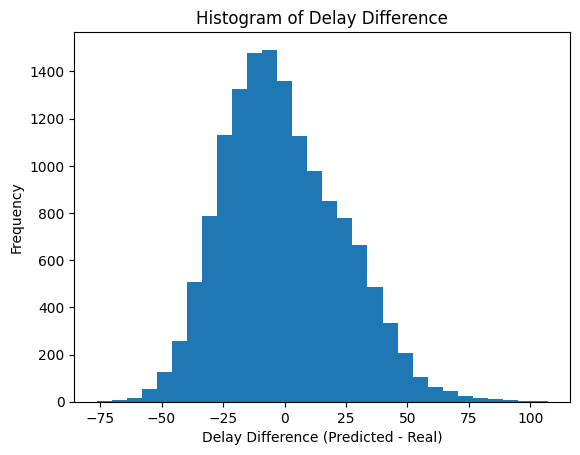

In [91]:
# Plot histogram of delay difference
plt.hist(y_test, bins=30)
plt.xlabel("Delay Difference (Predicted - Real)")
plt.ylabel("Frequency")
plt.title("Histogram of Delay Difference")
plt.show()

In [92]:
y_pred

array([ -7.96108134,  -7.96108134, -20.04060775, ...,  -7.96108134,
        23.73422599,  25.88425921])

In [93]:
y_test.values

array([ -7.30600702, -27.25779454, -25.91538058, ...,  14.50515961,
        10.24682305, -19.00159312])

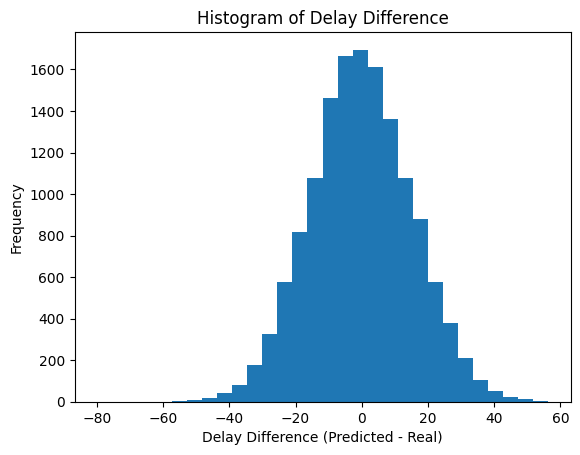

In [94]:
# Calculate the difference between predicted and real delays
delay_diff = y_pred - y_test

# Plot histogram of delay difference
plt.hist(delay_diff, bins=30)
plt.xlabel("Delay Difference (Predicted - Real)")
plt.ylabel("Frequency")
plt.title("Histogram of Delay Difference")
plt.show()